In [1]:
using Pkg
Pkg.add("OSQP")
Pkg.add("Compat")

   Updating registry at `/opt/julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
  Installed MutableArithmetics ─ v0.2.12
  Installed OSQP ─────────────── v0.6.0
  Installed ZipFile ──────────── v0.9.3
  Installed CodecBzip2 ───────── v0.7.2
  Installed JSONSchema ───────── v0.3.2
  Installed BenchmarkTools ───── v0.5.0
  Installed MathProgBase ─────── v0.7.8
  Installed MathOptInterface ─── v0.9.18
Updating `/opt/julia/environments/v1.5/Project.toml`
  [ab2f91bb] + OSQP v0.6.0
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
  [523fee87] + CodecBzip2 v0.7.2
  [7d188eb4] + JSONSchema v0.3.2
  [b8f27783] + MathOptInterface v0.9.18
  [fdba3010] + MathProgBase v0.7.8
  [d8a4904e] + MutableArithmetics v0.2.12
  [ab2f91bb] + OSQP v0.6.0
  [a5390f91] + ZipFile v0.9.3
   Building OSQP → `/opt/julia/packages/OSQP/BU4WO/deps/build.log`
  Resolving package versions...

**Example 1: Toy Problem**

\begin{split}\begin{array}{ll}
  \mbox{minimize} & \frac{1}{2} x^\top \begin{bmatrix}2 & 1\\ 1 & 2 \end{bmatrix} x + \begin{bmatrix}1 \\ 1\end{bmatrix}^\top x \\
  \mbox{subject to} & \begin{bmatrix}1 \\ 0 \\ 0\end{bmatrix} \leq \begin{bmatrix} 1 & 1\\ 1 & 0\\ 0 & 1\end{bmatrix} x \leq  \begin{bmatrix}1 \\ 0.7 \\ 0.7\end{bmatrix}
\end{array}\end{split}

In [2]:
using OSQP
using Compat.SparseArrays

# Define problem data
P = sparse([2. 0.; 0. 2.])
q = [-4.; -2.]
A = sparse([1. 2.; 3. 3.; 1. 0.; 0. 1.])
l = [0.; 0.; 0.; 0.]
u = [12.; 25.; 7.; 5.]

# Crate OSQP object
prob = OSQP.Model()

# Setup workspace and change alpha parameter
OSQP.setup!(prob; P=P, q=q, A=A, l=l, u=u)

# Solve problem
results = OSQP.solve!(prob);

# Print optimal x
println(results.x)

┌ Info: Precompiling OSQP [ab2f91bb-94b4-55e3-9ba0-7f65df51de79]
└ @ Base loading.jl:1278


[1.9999999999964584, 0.9999999999954644]
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 4
          nnz(P) + nnz(A) = 8
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -4.4887e+00   7.69e-16   1.29e+00   1.00e-01   6.90e-05s
  25  -5.0000e+00   1.54e-15   9.07e-12   1.00e-01   8.75e-05s

status:  

**Example 2: Max Margin Classifier**

\begin{split}\begin{array}{ll}
  \mbox{minimize} & \frac{1}{2} w^\top w \\
  \mbox{subject to} & y_i (w^\top x_i) \geq 1 \qquad i = 1,\dots,n
\end{array}\end{split}

In [3]:
# generate a dataset
stop = false;
k1 = 0; # number of 1
k2 = 0; # number of -1
X = zeros(100,2); # input matrix
t = zeros(100,1); # target values
i = 1;
while !stop
    x = rand(1,2) * 5.;
    # separating line is x2 = 1.5 x1 + 0.4
    y = x[2] - 1.5 * x[1] - 0.4;
    # generate target values
    if (y > 0.02) && k1 < 50
        t[i] = 1;
        X[i,:] = x;
        k1 += 1;
        i += 1;
    elseif (y < -0.02) && k2 < 50
        t[i] = -1;
        X[i,:] = x;
        k2 += 1;
        i += 1;
    elseif k1 > 49 && k2 > 49
        break;
    end
end

# Class +1 IDs
class1_id = t .== 1;

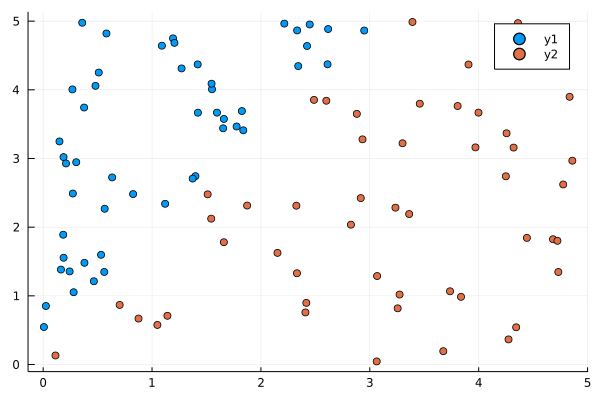

In [4]:
using Plots
gr() # Set the backend to GR

plot(X[class1_id[:],1], X[class1_id[:],2], seriestype = :scatter)
plot!(X[.!class1_id[:],1], X[.!class1_id[:],2], seriestype = :scatter)

In [5]:
using OSQP
using SparseArrays
using LinearAlgebra 

# Define problem data
P = sparse(zeros(3,3) + I);
q = zeros(3,1);
A = -sparse([t t t] .* [X ones(size(X,1),1)]);
l = zeros(size(X,1),1) .- Inf
u = -ones(size(X,1),1);

# Crate OSQP object
prob = OSQP.Model()

# Setup workspace and change alpha parameter
OSQP.setup!(prob; P=P, q=q[:], A=A, l=l[:], u=u[:])

# Solve problem
results = OSQP.solve!(prob);

println(results.x)

[-10.870823072226536, 7.38409871074419, -2.8707887506720144]
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 3, constraints m = 100
          nnz(P) + nnz(A) = 303
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   4.32e+00   1.00e-01   1.02e-04s
 200   4.5774e+01   4.03e-01   1.28e+00   5.54e-0

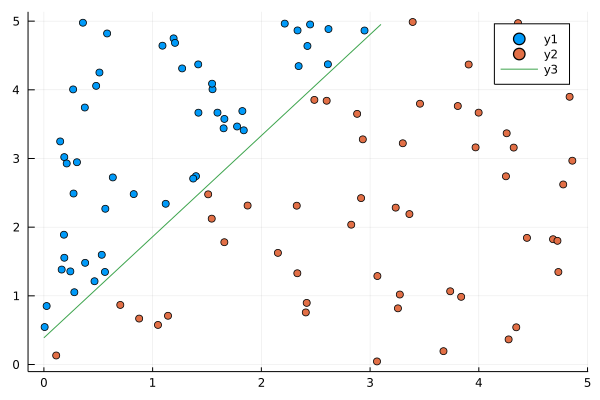

In [6]:
w_line = -results.x ./ results.x[2];

x_line = collect(0:0.1:3.1)
y_line = w_line[1] * x_line .+ w_line[3]
plot!(x_line, y_line)